# Variable Length Motif Discovery for User Interaction Logs

Enhancing the publication of Hohenadl to reduce the dependency on window size

In [1]:
import sys
sys.path.append('../') # To import from parent dir
import os

import time

import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
import ast
import math

from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder

import util.GrammarBasedUtil as grammar_util
import util.ui_stump as ui_stump

import util.valmod_uihe as valmod_util
from util.util import encoding_UiLog, read_data_for_processing, print_progress_bar
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain

# LOCOmotif multi variate variable length motif discovery
# Source: https://github.com/ML-KULeuven/locomotif/tree/main
# Paper:  https://link.springer.com/article/10.1007/s10618-024-01032-z
import locomotif.locomotif as locomotif 
import util.locomotif_vis as visualize

from experiment import run_experiment

import warnings
# Example: Only show a warning once globally
warnings.filterwarnings('ignore', category=UserWarning)

c:\Users\tomho\anaconda3\envs\tsrdFall2025\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Run the Complete Experiment

On a 32GB RAM Win 11 Machine Runtimes for logs are around
- Log length 250 ~0.02 seconds
- Log length 150000 ~45 Minutes
- Log length 225000 ~6.5 Hours

In [ ]:
validation_data_path = "../logs/smartRPA/202511-update/validationLogInformation.csv"
validation_data = pd.read_csv(validation_data_path)
output_csv_path = "../logs/smartRPA/202511-update/validation_experiment_results_word2vec_compCorpus_safety2_overlap0_8.csv"

if os.path.exists(output_csv_path):
    results_df_collector = pd.read_csv(output_csv_path, sep=';')
else:
    results_df_collector = pd.DataFrame({"uiLogName": []})

# Iterate, run experiment, and save after each iteration
for index, row in validation_data.iterrows():
    log_name_smartRPA = row['uiLogName']
    log_length = row['logLength']
    if log_name_smartRPA in results_df_collector['uiLogName'].values:
        print(f"Skipping already processed log: {log_name_smartRPA}")
        continue  # Skip already processed logs
    elif log_length > 100001:
        # Will run in OOME error with large logs, skip to avoid long runtimes
        print(f"Log {log_name_smartRPA} is too large ({log_length} events). Skipping processing to avoid long runtimes.")
        df_experiment_result = pd.DataFrame([{"uiLogName": log_name_smartRPA, "error_message": "Log too large, skipped processing."}])
    else:
        # Run the experiment for the current log
        try:
            df_experiment_result = run_experiment( # Ensure run_experiment returns a single-row DataFrame with uiLogName
                log_name_smartRPA=log_name_smartRPA,
                printing=False,
                plotting=False,
                safety_margin_factor=2,
                overlap_threshold=0.8
            )
        except Exception as e:
            print(f"Error processing {log_name_smartRPA}: {e}")
            df_experiment_result = pd.DataFrame([{"uiLogName": log_name_smartRPA, "error_message": str(e)}])  # Create an empty DataFrame on error
    
    # Merge current validation_data row with experiment result
    # Convert 'row' Series to a DataFrame to allow merging
    current_row_df = pd.DataFrame([row.to_dict()])
    current_row_df_with_results = pd.merge(current_row_df, df_experiment_result, on='uiLogName', how='left')

    # Append the combined row to the collector DataFrame
    # Use ignore_index=True as we're building it row by row
    results_df_collector = pd.concat([results_df_collector, current_row_df_with_results], ignore_index=True)
    
    # Save to CSV after each iteration
    # Use header=True only for the first save, then False for subsequent appends
    mode = 'w'
    header = True 
    results_df_collector.to_csv(output_csv_path, mode=mode, header=header, index=False)
    
    print(f"Saved results for {log_name_smartRPA} to {output_csv_path}")
    print_progress_bar(index + 1, len(validation_data))

print("\nFinal DataFrame collected (last state before loop finished):")
print(results_df_collector)

Skipping already processed log: log_motifs5_occurances5_length5_percentage1_shuffle0.csv
Skipping already processed log: log_motifs5_occurances5_length5_percentage1_shuffle0.1.csv
Skipping already processed log: log_motifs5_occurances5_length5_percentage1_shuffle0.2.csv
Skipping already processed log: log_motifs5_occurances5_length5_percentage10_shuffle0.csv
Skipping already processed log: log_motifs5_occurances5_length5_percentage10_shuffle0.1.csv
Skipping already processed log: log_motifs5_occurances5_length5_percentage10_shuffle0.2.csv
Skipping already processed log: log_motifs5_occurances5_length5_percentage25_shuffle0.csv
Skipping already processed log: log_motifs5_occurances5_length5_percentage25_shuffle0.1.csv
Skipping already processed log: log_motifs5_occurances5_length5_percentage25_shuffle0.2.csv
Skipping already processed log: log_motifs5_occurances5_length5_percentage50_shuffle0.csv
Skipping already processed log: log_motifs5_occurances5_length5_percentage50_shuffle0.1.csv

# Configuration of Parameters for discovery

Set the following parameters to test our approach in different scenarions.
You can choos to set:

- **isSmartRPA** to **TRUE** if you want a smartRPA example log to be processed.
- **log_name_smartRPA** to **[LOGNAME]** if you want a specific log to be processed. If no log is entered the default is **LenLog_1_1_10_25_5_5000.csv**

- **isActionLogger** to **TRUE** if you want one of the Leno et al. logs to be processed.
- **leno_plus** to **TRUE** if you want the log first containing all student record routines before all reimbursement routines, if set to **FALSE** the student records and reimbursement routines alternate

- **isRealWorldTest** to **TRUE** if you want to test the approach on a small, real-world data set.

- **isHCI** to **TRUE** if you want a human-computer interaction log as a test sample. Please note: This log has only few attributes compared to a UI log and thus does not work properly. Furthermore it only contains routine executions and no inter-routine noise.

**PLEASE NOTE** The first **TRUE** value will be processed. If you want to have one of the later values to be processed, you have to set all previous values (expect leno_plus) to **FALSE**

#### Parameters

- **rule_density_threshold** is a threshold for Rule Density in Re-Pair. It increases the Grammar Rule Peak range by extending left and right until the rule count density drops below this threshold. E.g. setting the threshold at 0.8, if the rule-peak is at 10, the rules around this peak going to 8 or above will be included in the identified rule pattern.

- **stumpy_discovery_threshold** Threshold for STUMPY discovery as a true positiv when overlapping at least this much with a ground truth motif

- **app_switch_similarity_threshold** Threshold for considering a pattern drop in all discovered motifs as a pattern switch >> If less than x % share the same app, we consider this a switch

#### About the data

Depending on the selection before of the parameters of this notebook, the code prepares the data to make the notebook run smooth.
If a new log should be process-able, the preprocessing has to be added in the **uti.util.read_data_for_processing** function.

The following data is prepared for processing:
1. The context parameter levels according to the UI hierarchy reference model
   1. Each hierarchy level as an individual list
   2. hierarchy_list: A list of lists
   3. hierarchy_columns: A flattend (concatenated) list of the context parameters
2. The Ground Truth for Experiment comparison (Dataframe with columns: start_index, end_index, length)
3. CSV Read of the log(s)

#### Dataset Sources:

**SmartRPA**
Source: https://zenodo.org/records/6518291
Creation of noisy data as defined in: 04_validationLogCreation.ipynb

**Leno**
Source: https://figshare.com/articles/dataset/UI_logs/12543587/4
Extension with noise from Hohenadl: https://link.springer.com/chapter/10.1007/978-3-032-02936-2_20

**Real World Log**
The real world log is a recording of one of the authors over multiple distributed periods of research. The authors have cleaned the log by removing all identifiers of the author, any passwords or account names.

**HCI**
Source: https://springernature.figshare.com/collections/A_dataset_of_human-machine_interactions_for_a_smarter_UX/6612805

Setup of Data and reading of necessary files for SmartRPA validation



-------------------------------------------

**STEP 1**

Set the described parameters. After setting these according to your preference you can use **RUN ALL** in VS Code or similar methods in your IDE.

In [45]:
# Select the encoding method
# 1 - Word2Vec based encoding on context parameters
# 2 - Hierarchical encoding on context parameters
# 3 - Co-Occurrance Encoding
encoding_method = 1

# ---- Define if you want to process a sample Smart RPA Log ----
isSmartRPA2024 = False
# log_name_smartRPA = "LenLog_1_1_10_25_5_5000.csv" # 1 Routine Type, 10 Occurrances, 25 Routine Length, 5% of Log are Motifs
# log_name_smartRPA = "LenLog_1_10_1_10_5_1_5000.csv" # 1 Routine Type, 10 Intra-Routine Noise, 10 Occurances, 5 Routine Length, 1% of Log are Motifs
log_name_smartRPA = "LenLog_1_20_1_15_15_1_22500.csv" # 1 Routine Type, 20 Intra-Routine Noise, 15 Occurances, 15 Routine Length, 1% of Log are Motifs
log_name_smartRPA = "LenLog_1_20_1_15_25_1_37500.csv" # 1 Routine Type, 20 Intra-Routine Noise, 15 Occurances, 25 Routine Length, 1% of Log are Motifs
log_name_smartRPA = "LenLog_1_20_1_10_5_1_5000.csv"

# ---- Smart RPA New 2025 Validation Data for Var Length Motif Discovery ----
isSmartRPA2025 = False
log_name_smartRPA = "log_motifs5_occurances5_length20_percentage10_shuffle0.csv"

# ---- Leno Sequential Log ----
isActionLogger = True
leno_plus = False # Set True if Leno Plus (First all SR then RT), False if Leno Parallel (SR and RT interleaved)
leno_extended = True # Set True if Leno Logs with noise (True for Extended Logs, False for original Leno Logs SRRTplus and SRRTparallel)

# ---- Real World Test Recording Author ----
isRealWorldTest = False

# ---- HCI Based Log ----

isHCI = False

# ---- Generic Parameters that were tested in other publications ----
rule_percentile_threshold = 0.90 # Percentile Threshold for Rule Density in Re-Pair >> Grammar Rule Peak is extended left and right until the rule count density drops below this percentile
rule_density_threshold = 0.8 # Threshold for Rule Density in Re-Pair >> Grammar Rule Peak is extended left and right until the rule count density drops below this threshold
app_switch_similarity_threshold = 0.75 # Threshold for considering a pattern drop in all discovered motifs as a pattern switch >> If less than x % share the same app, we consider this a switch
rho_LoCoMotif = 0.6 # Rho parameter for LoCoMotif variable length motif discovery
overlap_threshold = 0.8 # Threshold for considering a discovered motif as a true positive when overlapping at least this much with a ground truth motif >> Same as in Hohenadl 2025


# ---- Parameters for Stumpy Matrix Profile ----
stumpy_discovery_threshold = 0.5 # Threshold for STUMPY discovery as a true positiv when overlapping at least this much with a ground truth motif

**STEP 2** 

Read the data and gather the parameters for processing.

In [46]:
data_for_processing = read_data_for_processing(isSmartRPA2024=isSmartRPA2024,
                                               isSmartRPA2025=isSmartRPA2025,
                                                    isRealWorldTest=isRealWorldTest,
                                                    isActionLogger=isActionLogger,
                                                    leno_plus=leno_plus,
                                                    leno_extended=leno_extended,
                                                    isHCI=isHCI,
                                                    log_name_smartRPA=log_name_smartRPA,
                                                    encoding_method=encoding_method)

# Unpack the returned dictionary
hierarchy_list = data_for_processing["hierarchy_list"]
hierarchy_columns = data_for_processing["hierarchy_columns"]
hierarchy_columns_app_switch = data_for_processing["hierarchy_columns_app_switch"]
file = data_for_processing["file"]
log = data_for_processing["log"]
ground_truth = data_for_processing["ground_truth"]
ui_log_encoded = data_for_processing["ui_log_encoded"]
ground_truth_start_list = data_for_processing["ground_truth_start_list"]
column_identifier = data_for_processing["column_identifier"]

# Filter out hierarchy columns that have zero unique values
hierarchy_columns = [
    col for col in hierarchy_columns
    if log[col].nunique() != 0
]
tokens = 0
for col in hierarchy_columns:
    tokens += log[col].nunique()
token_based_vector_size = round(math.sqrt(tokens))

total_start_time = time.time()
# Apply the Grammar Based Rule Discovery and print a sample rule tree
encoding_df, symbols, two_gram_df = grammar_util.re_pair(log)
repair_time = time.time()
last_entry = len(encoding_df["new_symbol"])-1
last_encoding = encoding_df["new_symbol"].iloc[last_entry]
print("\n Last Encoded Entry: ",last_encoding)
# Just for visualization purposes
# decoded_symbol = grammar_util.re_pair_decode_symbol(last_encoding, encoding_df, printing=True)
log = grammar_util.generate_density_count(encoding_df, log)
density_count_time = time.time()

Processing file: 202511_extended_SR_RT_parallel.csv with 9646 events.
Using Word2Vec based encoding for UI Log

 Last Encoded Entry:  lm


**STEP 3**
Calculate and Visualize the Rule-Density Curve based on Ground Truth data.

In [47]:
# Find the maximum density groups based on the rule density count
max_density_groups_from_rules, _ = grammar_util.find_max_density_groups(log,relative_threshold=rule_density_threshold,method="percentile",percentile_threshold=rule_percentile_threshold)
maximum_density_groups_df = pd.DataFrame(columns=["group","processed"])
maximum_density_groups_df["group"] = max_density_groups_from_rules

# Add start and end indices to the dataframe
maximum_density_groups_df["start_index"] = -1
maximum_density_groups_df["end_index"] = -1
maximum_density_groups_df["length"] = 0
for i, grammer_motif in maximum_density_groups_df.iterrows():
    maximum_density_groups_df.loc[i, "start_index"] = min(grammer_motif['group'])
    maximum_density_groups_df.loc[i, "end_index"] = max(grammer_motif['group'])
    maximum_density_groups_df.loc[i, "length"] = maximum_density_groups_df.loc[i, "end_index"] - maximum_density_groups_df.loc[i, "start_index"] + 1
    
start_indices = maximum_density_groups_df["start_index"].tolist()
end_indices = maximum_density_groups_df["end_index"].tolist()
max_density_groups_time = time.time()

**STEP 4** (Not Result Relevant)

Calculate the discovery scores for the rule-density counts based on the ground truth.

Just for evaluation purposes - Not timing relevant

Start Index of the first ground truth motif: 0
Maximum rule density count: 9
Longest identified motif length: 9


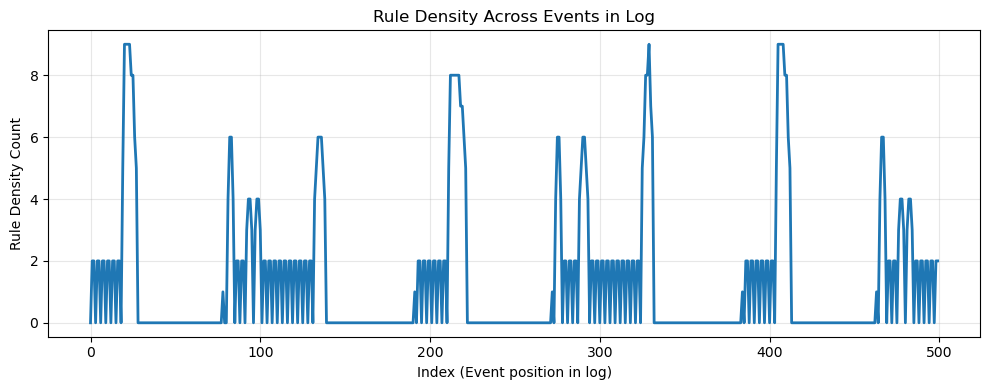

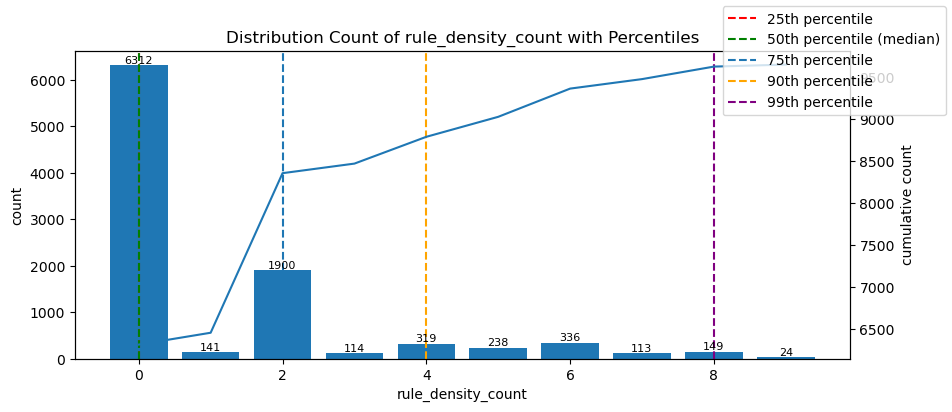

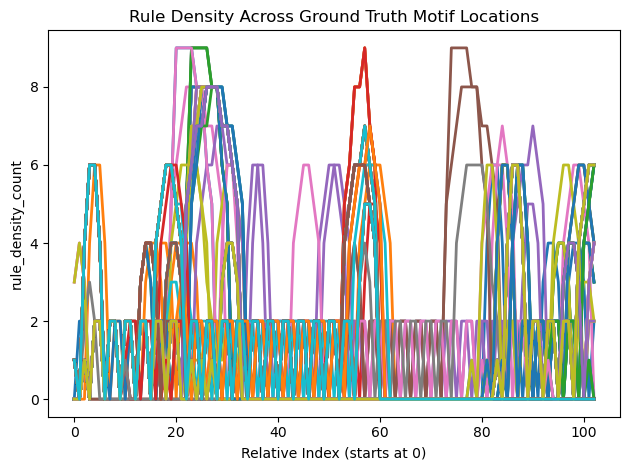

tp: 95.000
fp: 123.000
fn: 5.000
intersection_ratio: 1.000
intersection_abs: 5.408
undercount_ratio: 0.757
undercount_abs: 35.660
over_detection_ratio: 0.000
over_detection_abs: 0.000

Precision: 0.436, Recall: 0.950, F1: 0.597


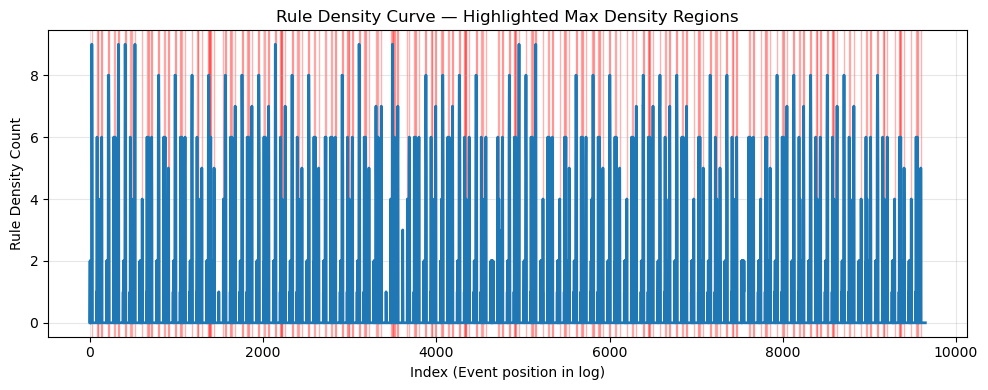

In [48]:
# ---- Visualisation Only ---- No Logic for subsequent processing ----
ground_truth.sort_values(by=["start_index"], inplace=True)
motiv = int(ground_truth.iloc[0]["start_index"])
print(f"Start Index of the first ground truth motif: {motiv}")
colors = plt.cm.tab10.colors
length = ground_truth["length"].max()
ground_truth = ground_truth.astype({'caseid': 'str', 'start_index': 'int', 'length': 'int', 'end_index': 'int'})

print(f"Maximum rule density count: {log['rule_density_count'].max()}")
max_length = -1
min_length = len(log)
for motif in maximum_density_groups_df["group"]:
    if len(motif) > max_length:
       max_length = len(motif)
       if len(motif) > 0 and len(motif) < min_length:
            min_length = len(motif)
            print(f"Longest identified motif length: {max_length}")
            
grammar_util.plot_density_curve(log, range_low=0, range_high=min(500, len(log)))
grammar_util.plot_rule_density_distribution(log, col_name="rule_density_count")

for i, start in enumerate(ground_truth["start_index"]):
    end = start+length+10
    y = log.iloc[int(start):int(end)]["rule_density_count"].to_numpy()
    x = range(len(y))  # all start at 0
    plt.plot(x, y, color=colors[i % len(colors)], linewidth=2, label=f"Range {start}-{end}")
    
plt.title("Rule Density Across Ground Truth Motif Locations") 
plt.xlabel("Relative Index (starts at 0)")
plt.ylabel("rule_density_count")
plt.tight_layout()
plt.show()

# ---- Evaluate the discovered motifs against the ground truth ----
stats_new = grammar_util.evaluate_motifs(maximum_density_groups_df["group"], ground_truth, overlap_threshold)

overlap_table = stats_new["overlap_table"]         # DataFrame for inspection
tp, fp, fn = stats_new["tp"], stats_new["fp"], stats_new["fn"]
for key, value in stats_new.items():
    if key != "overlap_table" and key != "matched_pairs":
        print(f"{key}: {value:.3f}")

precision = tp / (tp + fp) if (tp + fp) else 0
recall = tp / (tp + fn) if (tp + fn) else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

print(f"\nPrecision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

# ---- Plotting the results ----
plt.figure(figsize=(10, 4))
plt.plot(log.index, log["rule_density_count"], linewidth=2)
for g in max_density_groups_from_rules:
    plt.axvspan(g[0], g[-1], color="red", alpha=0.3)
plt.title("Rule Density Curve — Highlighted Max Density Regions")
plt.xlabel("Index (Event position in log)")
plt.ylabel("Rule Density Count")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**STEP 5**

Identify app switches and filter the original log to rule-density based motif candidates

**STEP 6** 

Execute variable length motif discovery on the filtered log using LoCoMotif.

Total Included Range Length: 5869 of 9646
Percentage of Log Included: 60.84%
Using Word2Vec based encoding for UI Log
Parts of the log that are retained after filtering based on pattern switches and safety margins:


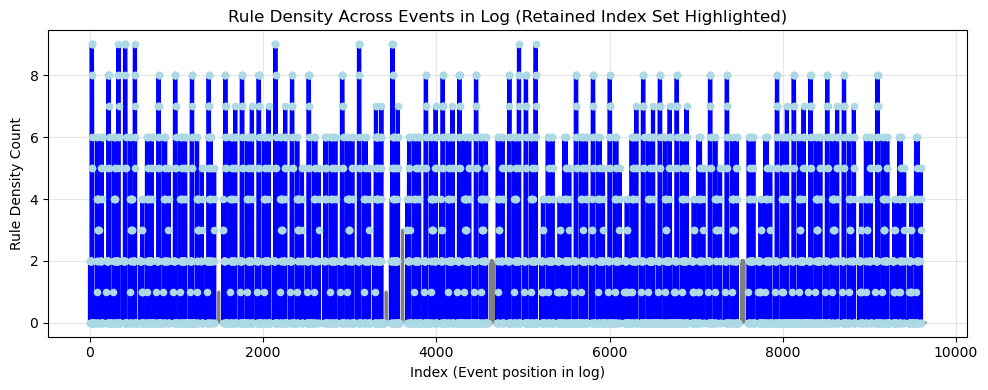

Rule Density Curve before Filtering:


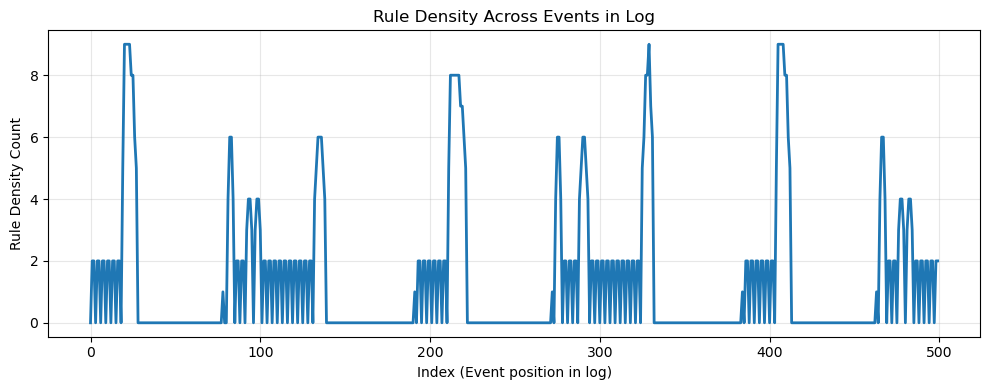

Rule Density Curve after Filtering:


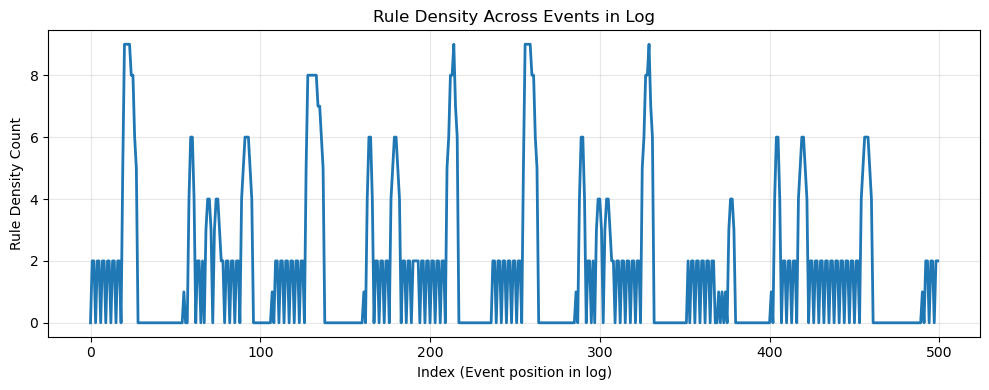

c:\Users\tomho\anaconda3\envs\tsrdFall2025\Lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


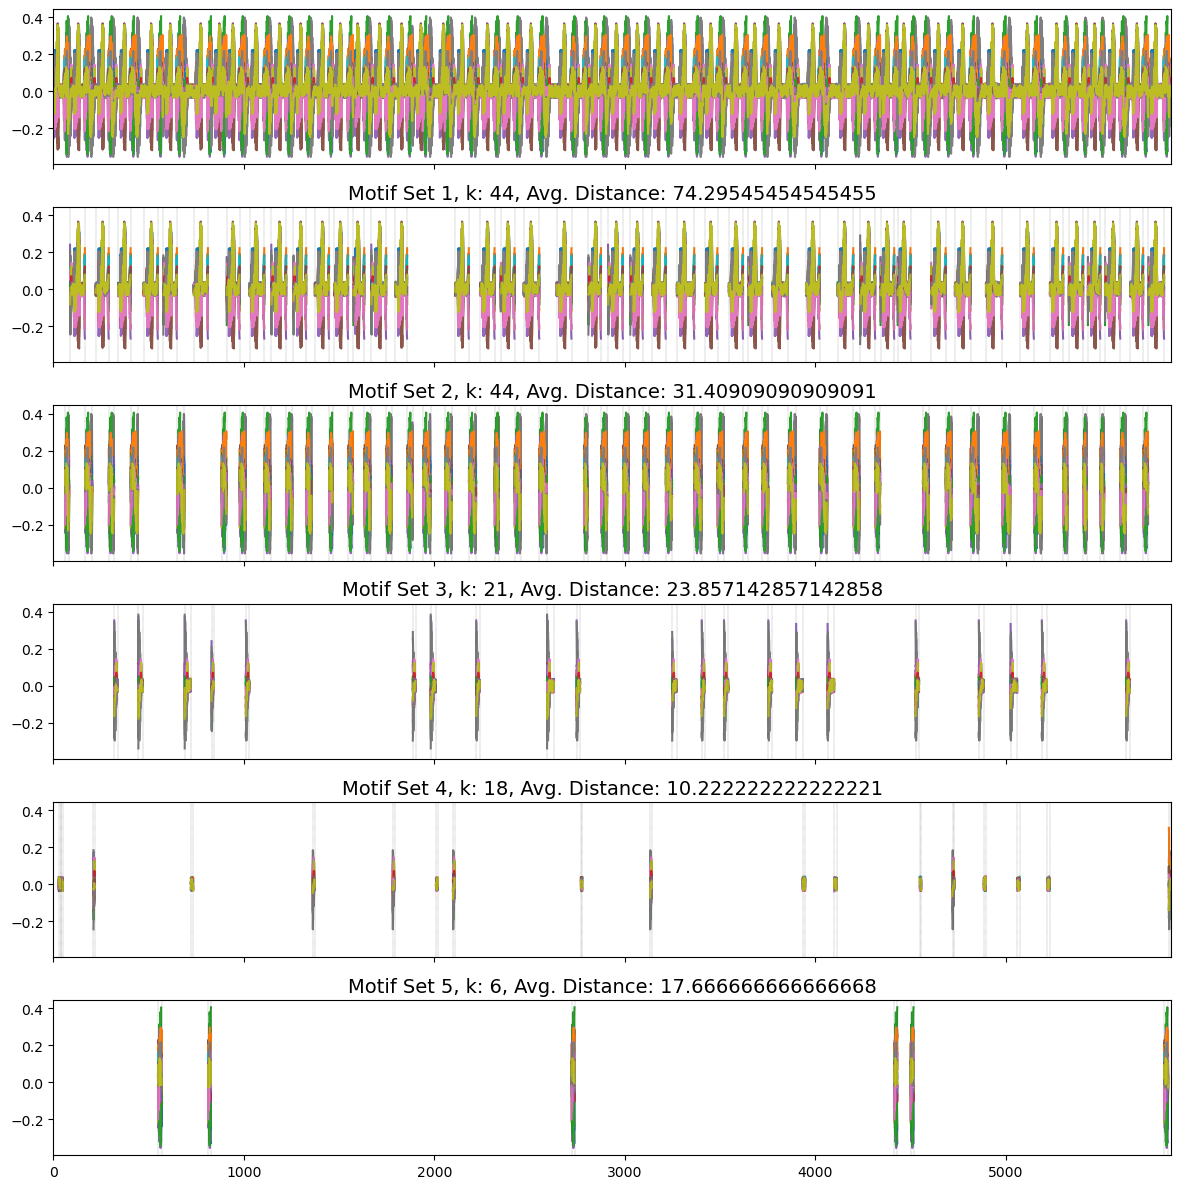

In [49]:
########################################################
##### App Switch, Pattern Mining and Safety Margin #####
########################################################

# Extend until the app changes for the specific pattern and add as "lower_app_switch" and "upper_app_switch"
max_groups_df = grammar_util.app_switch_miner(log, maximum_density_groups_df, hierarchy_columns_app_switch)
app_switch_mining_time = time.time()

lower_app_switches = max_groups_df["lower_app_switch"].tolist()
upper_app_switches = max_groups_df["upper_app_switch"].tolist()

# Mine the similar paths up and down until an app switch across discovered patterns is found
result_df = grammar_util.similar_path_up_down(
    df=log,
    max_groups_df=max_groups_df,
    start_indices=lower_app_switches,
    end_indices=upper_app_switches,
    cols=hierarchy_columns_app_switch,
    min_pairs=len(lower_app_switches)*app_switch_similarity_threshold, # At least 75% of the patterns should be similar in path
)


# build list of all valid index ranges
valid_indices = []

# Include additional safety margin from pattern switch
range_sum = 0
max_safety_margin = 0
for _, row in result_df.iterrows():
    # Set the safety margin as the distance between the pattern switches & apply factor to extend based on safety concern
    safety_margin = (int(row['upper_pattern_switch']) - int(row['lower_pattern_switch']))*2
    if safety_margin > max_safety_margin:
        max_safety_margin = safety_margin
    valid_indices.extend(range(max(0, int(row['lower_pattern_switch'])-safety_margin),
                            min(int(row['upper_pattern_switch'])+safety_margin, len(log)-1)))
    range_distance =  min(int(row['upper_pattern_switch'])+safety_margin, len(log)-1) - max(0, int(row['lower_pattern_switch'])-safety_margin)


# Convert the valid indices to a set to remove duplicates
valid_indices_set = set(valid_indices)
print(f"Total Included Range Length: {len(valid_indices_set)} of {len(log)}")
print(f"Percentage of Log Included: {len(valid_indices_set)/len(log)*100:.2f}%")

log_path_extension_time = time.time()

# filter log to include only those indices
filtered_log = log.loc[log.index.intersection(valid_indices)].copy()

# optionally, keep the original index as a column for traceability
filtered_log['original_index'] = filtered_log.index
filtered_log.reset_index(drop=True, inplace=True)

# Encode the filtered log
if encoding_method == 1:
    print("Using Word2Vec based encoding for UI Log")
    filtered_log_encoded = valmod_util.encode_word2vec(uiLog=filtered_log, 
                                                       orderedColumnsList=hierarchy_columns, 
                                                       vector_size=token_based_vector_size,
                                                       completeCorpusLog=log)
    column_identifier = 'w2v_'
elif encoding_method == 2:
    print("Using Hierarchical based encoding for UI Log")
    filtered_log_encoded = encoding_UiLog(filtered_log,orderedColumnsList=hierarchy_columns,encoding=1)
    column_identifier = 'tuple:id'
elif encoding_method == 3:
    print("Using Co-Occurrance based encoding for UI Log")
    filtered_log_encoded = encoding_UiLog(filtered_log,orderedColumnsList=hierarchy_columns,encoding=2)
    column_identifier = 'tuple:id'
else:
    raise ValueError("Invalid encoding method selected. Choose 1, 2, or 3.")

print("Parts of the log that are retained after filtering based on pattern switches and safety margins:")
grammar_util.plot_density_curve_with_index_set(log, valid_indices_set, column_name="rule_density_count")
df_filtered_for_plotting = filtered_log.reset_index(drop=True)
print("Rule Density Curve before Filtering:")
grammar_util.plot_density_curve(log, range_low=0, range_high=min(500, len(log)))
print("Rule Density Curve after Filtering:")
grammar_util.plot_density_curve(df_filtered_for_plotting, range_low=0, range_high=min(500, len(df_filtered_for_plotting)))

# Reduce the data to an ordered time series for locomotif
filtered_columns_reduced_log = filtered_log_encoded.filter(like=column_identifier)

# Optional: Normalization
ts = (filtered_columns_reduced_log - np.mean(filtered_columns_reduced_log, axis=None)) / np.std(filtered_columns_reduced_log, axis=None)

##########################################################
##### Variable Length Motif Discovery with LOCOmotif #####
##########################################################

# Calculate length statistics:
# l_min = Grammer Rule Density Length Mean - Std Dev
# l_max = Safety Margin from App switch analysis
l_min = max(5,maximum_density_groups_df["length"].mean() - maximum_density_groups_df["length"].std())
l_max = max_safety_margin

# Variable Length Motif Discovery >> Using the low from the GRAMMAR as l_min, Using the security margin from app switch as l_max
motif_sets = locomotif.apply_locomotif(filtered_columns_reduced_log, l_min=l_min, l_max=l_max, rho=rho_LoCoMotif)
locomotif_discovery_time = time.time()

# Plotting with adjusted locomotif visualization (utils)
fig, ax = visualize.plot_motif_sets(series=filtered_columns_reduced_log.values,
                                    motif_sets=motif_sets, 
                                    max_plots=5,
                                    legend=False)
plt.show()

**STEP 7**

Identify overlap between LOCOmotif and Re-Pair motifs to ensure that by the filtering step no additional motifs are inserted

In [50]:
blocks = []

for cluster_set in motif_sets:# Efficient slicing instead of isin()
    for cluster_motif in cluster_set[1:]:
        for motif in cluster_motif:
            
            start_of_discovered_motif = motif[0]
            end_of_discovered_motif = motif[1]
            length_of_discovered_motif = end_of_discovered_motif - start_of_discovered_motif
            motif_original_start_index = filtered_log.loc[start_of_discovered_motif, "original_index"]
            # print(f"Motif Start Index: {start}, Motif Length: {end}")
            # print(f"Motif Original Start Index in Full Log: {motif_original_start_index}")
            try:
                block = pd.DataFrame({
                    "original_df_range": [list(range(motif_original_start_index, motif_original_start_index+length_of_discovered_motif))],
                    "cluster_id": [cluster_set[0]],
                    "original_df_case_ids": [log.loc[motif_original_start_index:motif_original_start_index+length_of_discovered_motif, "case:concept:name"].tolist()],
                    "motif_length": length_of_discovered_motif
                })
            except KeyError as ke:
                block = pd.DataFrame({
                    "original_df_range": [list(range(motif_original_start_index, motif_original_start_index+length_of_discovered_motif))],
                    "cluster_id": [cluster_set[0]],
                    "original_df_case_ids": [log.loc[motif_original_start_index:motif_original_start_index+length_of_discovered_motif, "caseid"].tolist()],
                    "motif_length": length_of_discovered_motif
                })
            blocks.append(block)
  
result_mapped_to_original_index = pd.concat(blocks, ignore_index=True)

result_mapped_to_original_index = grammar_util.mark_overlaps_grammer_locomotif_indexed(result_mapped_to_original_index, max_groups_df, col_df1="original_df_range", col_df2="group")
total_end_time = time.time()

**STEP 8**

Final evaluation on the discovery with total (not seperatey by cluster > see Step 9)
- Recall
- Precision
- F1-score
- Overlap Rates

Final Evaluation of Discovered Motifs against Ground Truth:
Considering **all** discovered motifs from LOCOmotif without filtering step
tp: 96.000
fp: 63.000
fn: 4.000
intersection_ratio: 0.649
intersection_abs: 20.031
undercount_ratio: 0.323
undercount_abs: 15.660
over_detection_ratio: 0.351
over_detection_abs: 15.717

Precision: 0.604, Recall: 0.960, F1: 0.741

Final Evaluation of Discovered Motifs against Ground Truth:
Considering only those motifs that were also identified by Grammar Based Discovery
tp: 90.000
fp: 36.000
fn: 10.000
intersection_ratio: 0.736
intersection_abs: 23.944
undercount_ratio: 0.381
undercount_abs: 17.280
over_detection_ratio: 0.264
over_detection_abs: 16.333
Precision: 0.714, Recall: 0.900, F1: 0.796


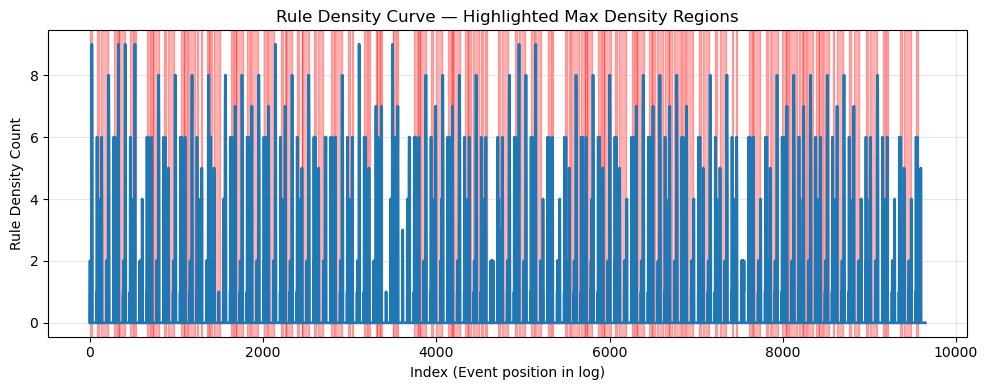

In [51]:
#########################################
#### Discovery before Grammer Filter ####
#########################################

print("Final Evaluation of Discovered Motifs against Ground Truth:")
print("Considering **all** discovered motifs from LOCOmotif without filtering step")

final_discovery_result = grammar_util.evaluate_motifs(result_mapped_to_original_index["original_df_range"], ground_truth, overlap_threshold)

overlap_table = final_discovery_result["overlap_table"]         # DataFrame for inspection
tp, fp, fn = final_discovery_result["tp"], final_discovery_result["fp"], final_discovery_result["fn"]
for key, value in final_discovery_result.items():
    if key != "overlap_table" and key != "matched_pairs":
        print(f"{key}: {value:.3f}")

precision = tp / (tp + fp) if (tp + fp) else 0
recall = tp / (tp + fn) if (tp + fn) else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

print(f"\nPrecision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

print("\nFinal Evaluation of Discovered Motifs against Ground Truth:")
print("Considering only those motifs that were also identified by Grammar Based Discovery")

########################################
#### Discovery after Grammer Filter ####
########################################

# Filter the result to only include clusters with grammar motif matches

motif_df = result_mapped_to_original_index[
    result_mapped_to_original_index["grammer_motif_match"] == True
].copy()

motif_df = motif_df.reset_index(drop=True)   # index = motif_id = 0..M-1

# Call evaluate_motifs with the aligned motif_df
final_discovery_result = grammar_util.evaluate_motifs(
    motif_df["original_df_range"],
    ground_truth,
    overlap_threshold
)

overlap_table = final_discovery_result["overlap_table"]         # DataFrame for inspection
tp, fp, fn = final_discovery_result["tp"], final_discovery_result["fp"], final_discovery_result["fn"]
for key, value in final_discovery_result.items():
    if key != "overlap_table" and key != "matched_pairs":
        print(f"{key}: {value:.3f}")

precision = tp / (tp + fp) if (tp + fp) else 0
recall = tp / (tp + fn) if (tp + fn) else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")


# ---- Plotting the results ---- 

plt.figure(figsize=(10, 4))
plt.plot(log.index, log["rule_density_count"], linewidth=2)
for g in result_mapped_to_original_index[result_mapped_to_original_index["grammer_motif_match"] == True]["original_df_range"].to_list():
    plt.axvspan(g[0], g[-1], color="red", alpha=0.3)
plt.title("Rule Density Curve — Highlighted Max Density Regions")
plt.xlabel("Index (Event position in log)")
plt.ylabel("Rule Density Count")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Step 9**

Calculate the motif discovery results on a cluster basis to identify if all existing routines are identified and how many routines are available

In [52]:
cluster_based_evaluation_df = grammar_util.join_discovery_with_ground_truth(final_discovery_result, ground_truth, motif_df)
if isSmartRPA2025: 
    # For Smart RPA 2025, we have case IDs in the format "motif[n]_caseid" in the ground_truth, which is the motif id in the Leno logs
    cluster_based_evaluation_df["motif"] = cluster_based_evaluation_df["motif_number"]
motif_res = grammar_util.motif_level_metrics(cluster_based_evaluation_df)
motif_purity = grammar_util.purity_per_two_columns(cluster_based_evaluation_df, cluster_by_col="motif", purity_col_name="cluster_id")
# print("Motif Level Metrics:")
# print(motif_res)
# print(motif_purity)
# print("\nCluster Level Metrics:")
cluster_res = grammar_util.cluster_level_metrics(cluster_based_evaluation_df)
cluster_purity = grammar_util.purity_per_two_columns(cluster_based_evaluation_df, cluster_by_col="cluster_id", purity_col_name="motif")
# print(cluster_res)
# print(cluster_purity)

In [53]:
motif_res

,motif,caseid,average_discovered_motif_length,precision,recall,f1,tp,fp,fn,required_total
0,RT,"[30, 40, 4, 22, 66, 94, 18, 12, 88, 56, 54, 58...",29.780,0.961538,1.0,0.980392,50,2,0.0,50.0
1,SR,"[29, 3, 21, 65, 93, 16, 11, 87, 55, 53, 59, 89...",73.875,0.975610,0.8,0.879121,40,1,10.0,50.0
2,UNMAPPED,-,0.000,0.000000,0.0,0.000000,36,0,0.0,NaN


**Step 10**

Compile execution times

In [54]:
# The times that are necessary to execute the discovery steps
# Works only if executed in sequence as above and with ">> Run All" cells 
print("\n--- Timing Summary (in seconds) ---")
print(f"Total Execution Time: {total_end_time - total_start_time:.2f} seconds")
print(f"Re-Pair Time: {repair_time - total_start_time:.2f} seconds")
print(f"Density Count Time: {density_count_time - repair_time:.2f} seconds")
print(f"Max Density Groups Time: {max_density_groups_time - density_count_time:.2f} seconds")
print(f"App Switch Mining Time:{log_path_extension_time - app_switch_mining_time:.2f} seconds")
print(f"LOCOmotif Discovery Time: {locomotif_discovery_time - log_path_extension_time:.2f} seconds")


--- Timing Summary (in seconds) ---
Total Execution Time: 204.30 seconds
Re-Pair Time: 1.83 seconds
Density Count Time: 3.92 seconds
Max Density Groups Time: 0.14 seconds
App Switch Mining Time:0.23 seconds
LOCOmotif Discovery Time: 192.05 seconds


#### Execution of LOCOMOTIF on complete log

The following code uses the same data as before, but instead of reducing the log down to high-rule based candidates it executed LoCoMotif on the complete dataset.

The parameters selected on the top of the Notebook apply.

Comment in with STRG+A > STRG+#

In [55]:
# # Reduce the data to an ordered time series for locomotif
# filtered_columns = ui_log_encoded.filter(like=column_identifier)

# # Optional: Normalization
# ts = (filtered_columns - np.mean(filtered_columns, axis=None)) / np.std(filtered_columns, axis=None)

# # Variable Length Motif Discovery
# motif_sets = locomotif.apply_locomotif(ts, l_min=5, l_max=65, rho=0.9)

# # Plotting with adjusted locomotif visualization (utils)
# fig, ax = visualize.plot_motif_sets(ts.values, motif_sets, max_plots=10,legend=False)
# plt.show()

In [56]:
# # build motif_df from valmod
# motif_intervals = []
# for motif, instances in motif_sets:
#     for s, e in instances:
#         motif_intervals.append((s, e))
# motif_df = pd.DataFrame(motif_intervals, columns=["motif_start", "motif_end"])

# def interval_overlap(a_start, a_end, b_start, b_end, tol=0):
#     return max(0, min(a_end + tol, b_end) - max(a_start, b_start - tol))

# tol = 0

# # 1) which motifs hit at least one GT?
# motif_hits = []
# for midx, m in motif_df.iterrows():
#     mstart, mend = m["motif_start"], m["motif_end"]
#     hit = False
#     for _, gt in ground_truth.iterrows():
#         if interval_overlap(mstart, mend, gt["start_index"], gt["end_index"], tol) > 0:
#             hit = True
#             break
#     motif_hits.append(hit)

# n_motifs = len(motif_df)
# n_motifs_hit = sum(motif_hits)
# precision = n_motifs_hit / n_motifs if n_motifs else 0.0

# # 2) which GT cases are hit by at least one motif?
# case_hits = []
# for _, gt in ground_truth.iterrows():
#     gstart, gend = gt["start_index"], gt["end_index"]
#     hit = False
#     for _, m in motif_df.iterrows():
#         if interval_overlap(gstart, gend, m["motif_start"], m["motif_end"], tol) > 0:
#             hit = True
#             break
#     case_hits.append(hit)

# n_cases = len(ground_truth)
# n_cases_hit = sum(case_hits)
# recall = n_cases_hit / n_cases if n_cases else 0.0

# f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

# print(f"precision={precision:.3f}, recall={recall:.3f}, f1={f1:.3f}")

### Execution of Word2Vec + MSTUMP

For comparison methods a word2vec based multi-dimensional motif discovery can be executed here.
This is based on the research paper by Hohenadl: https://link.springer.com/chapter/10.1007/978-3-032-02936-2_20

_________________________

**STEP 1**

Set Parameters

In [57]:
# size = 5  # For Word2Vec-Stump based Discovery
# motifs_to_discover = 60

**STEP 2**

Execute MSTUMP (Multi-Dimensional Motif Discovery) using the STUMPY implementation by Law: STUMPY: A Powerful and Scalable Python Library for Time Series Data Mining / https://joss.theoj.org/papers/10.21105/joss.01504

In [58]:
# # '# ground_truth => Dataframe with columns: caseid, start_index, length, end_index
# # # log => Dataframe with all events symbolized according to hierarchy_columns
# # # hierarchy_columns => List of Lists with all hierarchy levels used for symbolization
# # # hierarchy_list => Flattened list of hierarchy_columns

# motif_distances, motif_indices, motif_subspaces, motif_mdls = valmod_util.mine_w2v(ui_log_encoded,column_identifier,size,motifs_to_discover)
# print(f"Discovered Motif Indexes: {sorted(motif_indices[0])}")

# print(f"Ground Truth:{ground_truth}")

# # ---- Measuring Method: Half the Window Size ----
# # insert_spots, motif_spots, overlapDF = valmod_util.compare_sets(set(groundTruth), set(motif_indices[0]), (size/2))

# # >> Could be updated and use the ground truth dfs instean of the list
# original_inserts_indexes, discovered_motif_spots, overlapDF = valmod_util.compute_discovery_coverage(ground_truth_start_list, set(motif_indices[0]), size, threshold=stumpy_discovery_threshold)
# mean_coverage = 0

# if 'coverage' in overlapDF.columns:
#     mean_coverage = overlapDF.loc[:, "coverage"].mean()

# ground_truth_sum = len(ground_truth)
# true_positives = len(original_inserts_indexes)
# false_positives = motifs_to_discover - true_positives  # Incorrectly identified motifs
# false_negatives = ground_truth_sum - true_positives  # Relevant motifs not identified

# # Precision
# precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
# print(f"Precision: {precision}")

# # Recall
# recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
# print(f"Recall: {recall}")

# # F1-Score
# f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
# print(f"F1-Score: {f1_score}")

# # Create a figure with 1 row and 2 columns
# fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# # --- Bar Chart ---
# metrics = ['F1-Score', 'Recall', 'Precision', 'Coverage']
# values = [f1_score, recall, precision, mean_coverage]
# axes[0].bar(metrics, values, color='skyblue')
# axes[0].set_ylim(0, 1.05)  # Slightly higher to leave space for label

# axes[0].set_title('Performance Metrics', fontsize=14)
# axes[0].set_ylabel('Score', fontsize=12)

# for i, v in enumerate(values):
#     if v > 0.5:
#         offset = -0.05 if v > 0.98 else 0.02  # Push label down if bar is too high
#         axes[0].text(i, v + offset, f"{v:.2f}", ha='center', va='top' if offset < 0 else 'bottom', fontsize=10)

# axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# # --- Violin Plot with Points for IoU ---
# sns.violinplot(y=overlapDF["coverage"], ax=axes[1], inner=None, color='lightblue')
# sns.stripplot(y=overlapDF["coverage"], ax=axes[1], color='black', size=3, jitter=0.2)
# axes[1].set_title("Coverage Distribution (Violin Plot)", fontsize=14)
# axes[1].set_ylabel("Coverage", fontsize=12)
# axes[1].grid(axis='y', linestyle='--', alpha=0.6)

# plt.tight_layout()
# plt.show()